In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
import seaborn as sns; sns.set()

Written by: Kovalev Alexander  
Department:  MSU, Physics Faculty, Mathematical Modelling and Computer Sciencegr(MMCS), gr. 435    
  
  
   
Task: Compare LSM and Reduction when we posses information of the system

### Least square method
Ax = b  
$\hat{x} = (A^TA)^{-1}A^Tb$

In [32]:
np.dot(A,x).shape


(1000,)

In [37]:
def fit_MNK(A, b):
    if A.shape[0] != b.shape[0]:
        print( "Error in shapes")
    else:
        return np.dot(np.linalg.pinv(A),b) 

def squared_error(x_hat, x):
    mas_tmp = (x_hat - x)**2
    return mas_tmp.sum()/x.shape[0]
    

In [3]:
A = np.array([[2,0],
              [-1,1],
              [0,2]])
b = np.array([1,0,-1]).reshape(3,1)
print(A.shape, b.shape)
x_hat = fit_MNK(A, b)
x_hat

(3, 2) (3, 1)


array([[ 0.33333333],
       [-0.33333333]])

### Reduction [$A$, $F$,$\Sigma$,$X_0 $]
We exploit out knowledge about signal and noise  
Ax = b  ,   
$\hat{x} = x_0 + FA^T(AFA^T + \Sigma)^{-1}(b - Ax_0)$  

$x_0 $ - expected value of random vector(It is also vector)  
$\Sigma$  -  correlation matrix of out noise (ff)


 F - covariance matrix of signals which we wanna restore (f - Ef)(f - Ef)

In [153]:
def corr_new(x):
    mas = np.identity(x.shape[0])
    mas *= x.std()**2
    for i in range(mas.shape[0]):
        for j in range(mas.shape[0]):
            if mas[i, i] == mas[i, j]:
                mas[i,j] = mas[i,i]
    return mas

In [142]:
def fit_reduction(A, b, x, error):
    F = corr_new(x)
    #error = np.random.randn(b.shape[0])
    sigma = corr_new(error)
    x_0 = x.mean()
    x_0 = np.full_like(x, x_0).reshape(x.shape[0], 1)
    b = b.reshape(b.shape[0],1)

    
    matrix_tmp = np.dot(A, np.dot(F, A.T) + sigma)
    matrix_tmp = np.linalg.inv(matrix_tmp)
    matrix_tmp = np.dot(A.T, matrix_tmp)
    
    x_hat = x_0 + np.dot(np.dot(F, matrix_tmp),(b - np.dot(A, x_0)))
    return x_hat


#### Signal and convolution operator
Work with convolution and random input signal. With uniform distribution


In [ ]:
def squared_error(x_hat, x):
    x_hat = x_hat.reshape(x_hat.shape[0],1)
    x = x.reshape(x.shape[0],1)
    mas_tmp = (x_hat - x)**2
    return mas_tmp.sum()


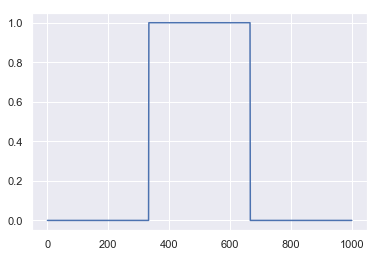

In [12]:


N = 1000
conv_fun = np.zeros(N)
conv_fun[int(N/3):int(2*N/3)] = 1
plt.plot(conv_fun)

In [13]:
# create convolutional operator
array = [0,0,1,1,0,0]
def array_shift(array, shift = 'right'):
    """смещаем массив в сторону, добавляя ноль"""
    if shift == 'right':
        return np.insert(array, 0, 0)[:-1] # add 0 in the beginning
    elif shift == 'left':
        return np.append(array, 0)[1:]
    else:
        print('Shift incorrect')

In [14]:
def build_conv_operator(conv_fun):
    
    N = conv_fun.shape[0]
    mas = np.zeros((N, N))
    
    # у нас ведь свертка а не кросс валидация, поэтому сделаем разворот.
    conv_fun =  np.flip(conv_fun)
    mas[N//2,:] = conv_fun
    for i in range(N//2, 0,-1):
        mas[i-1, :] = array_shift(mas[i, :], 'left')
    for i in range(N//2, N-1, 1):
        mas[i+1, :] = array_shift(mas[i, :], 'right')
    return mas
    
        

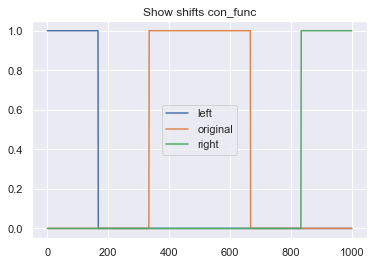

In [15]:
operator = build_conv_operator(conv_fun)

plt.title("Show shifts con_func")
plt.plot(operator[0,:], label = 'left')
plt.plot(operator[N//2,:], label = 'original')
plt.plot(operator[-1,:], label = 'right')
plt.legend()

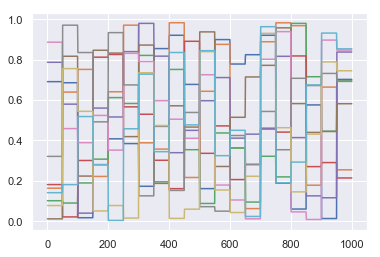

In [186]:
func = np.linspace(0,1,N) 

def create_sample(amount, N):
    mas = np.zeros((amount, N))
    for num in range(amount):
        func = np.zeros(N)
        for i in range(0, N, 50):
            func[i:i+100] = np.random.random()
        mas[num] = func
    return mas
signals = create_sample(10, N)
#func = func + np.random.randn(func.shape[0])/100
#func = np.sin(np.linspace(0,10,N))
plt.plot(signals.T)

In [178]:
squared_error(x,x),squared_error(x,x_hat_2)

(0.0, 0.11925654306106373)

 Error MSE 40.33693607638936 
 Error reduction 0.10136939031148418


AttributeError: 'list' object has no attribute 'mean'

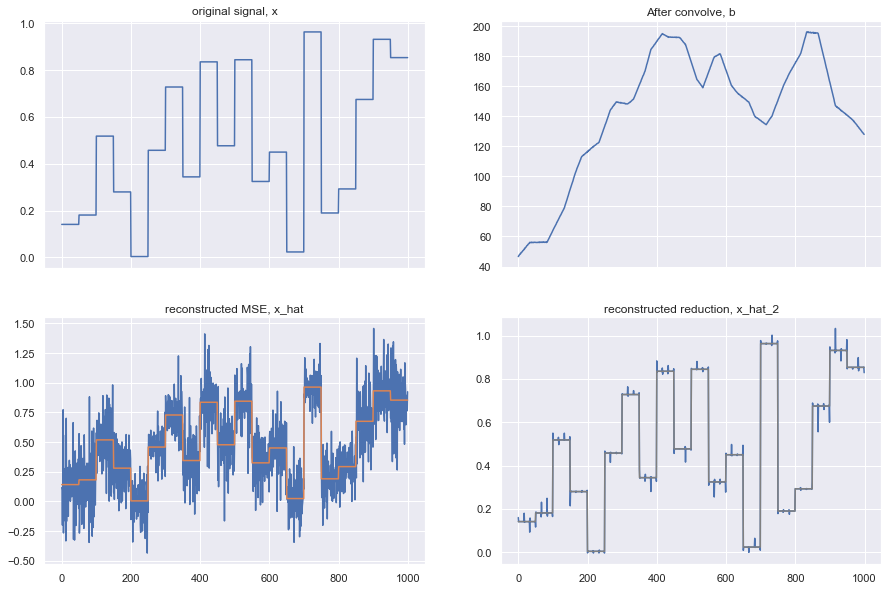

In [197]:
x = signals[-1]
A = build_conv_operator(conv_fun)
b = np.dot(A, x)
error = np.random.randn(func.shape[0])/10
b += error


x_hat = fit_MNK(A, b)
x_hat_2 = fit_reduction(A, b-error, x, error)

#
mas_errors_MSE = []
mas_errors_reduction = []
for i in range(signals.shape[0]):
    b = np.dot(A, signals[i])
    b += error
    x_hat = fit_MNK(A, b)
    x_hat_2 = fit_reduction(A, b-error, x, error)
    mas_errors_MSE.append(squared_error(x_hat, x))
    mas_errors_reduction.append(squared_error(x_hat_2, x))

fig, ax = plt.subplots(2,2, sharex=True, figsize = (15,10))
ax[0,0].set_title('original signal, x')
ax[0,0].plot(x)

ax[0,1].set_title('After convolve, b')
ax[0,1].plot(b)

ax[1,0].set_title('reconstructed MSE, x_hat')
ax[1,0].plot(x_hat)
ax[1,0].plot(x)

ax[1,1].set_title('reconstructed reduction, x_hat_2')
ax[1,1].plot(x_hat_2)
ax[1,1].plot(x, 'gray')

#plt.title('predict')
#plt.plot(x_hat) ## some noise it is very bad. Because bad signals with hopping

print(" Error MSE", squared_error(x_hat, x),'\n Error reduction',  squared_error(x_hat_2, x))
print(" Average MSE", mas_errors_MSE.mean(), '\n Average reduction',mas_errors_reduction.mean() )


In [198]:
print("10 samples: \n Average MSE ",np.mean(mas_errors_MSE), '\n Average reduction',np.mean(mas_errors_reduction) )

10 samples: 
 Average MSE  182.32373362958398 
 Average reduction 142.0144255131197


10

In [164]:
print(x_hat.shape, x_hat_2.shape)
(np.abs(x_hat-x)**2).sum(), (np.abs(x_hat_2-x)**2).sum()




(1000,) (1000, 1)


(41.219903451948944, 153607.73324019503)

In [173]:
print(" Error MSE", squared_error(x_hat, x),'\n Error reduction',  squared_error(x_hat_2, x))

 Error MSE 0.041219903451948946 
 Error reduction 0.00032302616802411314
